# Random Forest Model on Titanic Data

The goal of this project is to use random forest to predict survivability on titanic dataset

## Dataset Features
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson

In [575]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc,balanced_accuracy_score, roc_curve,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [576]:
def hypothesis_statistics(s1, s2,  p1, p2, alpha):
  P1  = s1/p1
  P2 = s2/p2
  p = (s1 + s2)/(p1 +p2)
  Z = (P1 - P2)/math.sqrt(p * (1-p)* ((1/p1)+(1/p2)))
  alp = st.norm.ppf(1 - (alpha/2))

  if Z < alp:
    return f"{Z} Test does not fall in rejection region, Accept H0"
  else:
    return f"{Z} Test falls within rejection region, reject H0"

In [577]:
data = pd.read_csv("https://raw.githubusercontent.com/komus/business_analytics/master/tree_based_model/titanic3.csv")
train = pd.read_csv("https://raw.githubusercontent.com/komus/business_analytics/master/tree_based_model/titanic_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/komus/business_analytics/master/tree_based_model/titanic_test.csv")

# EDA

In [578]:
data.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

## Does sex impact survival on the titanic?

- Although there are more men onboard the Titanic, the number of women saved is almost twice those of men. The survival rate of a woman is 73% while that of men is 19%. 
- Two proportion Z test confirms that the survival rate of men and women are not equal at 95% confidence
- Preference was given to female
- Therefore, you have a higher chance of surviving as a female on titanic than male

In [579]:
sex_survival =pd.crosstab(data.survived, data.sex)
sex_survival

sex,female,male
survived,,
0,127,682
1,339,161


In [580]:
pd.crosstab(data.survived, data.sex, normalize='columns')


sex,female,male
survived,,
0,0.272532,0.809015
1,0.727468,0.190985


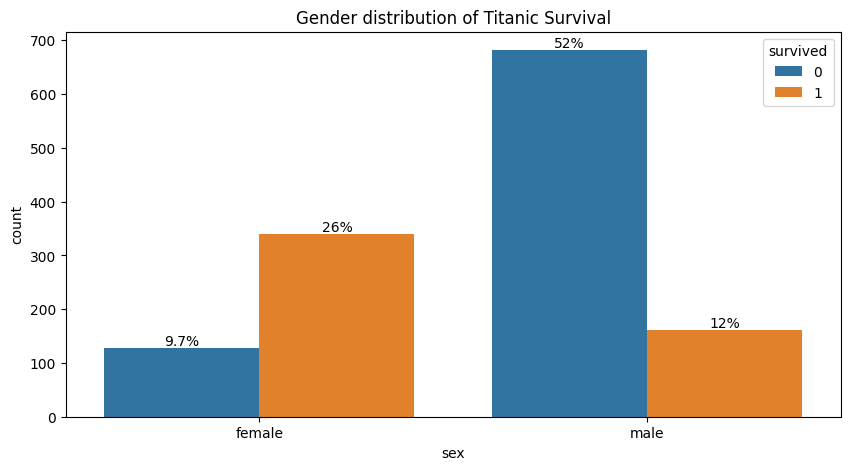

In [581]:
plt.figure(figsize=(10, 5))
g = sns.countplot(x="sex", hue="survived", data=data)
for p in g.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  g.annotate('{:.2g}%'.format(100.*y/len(data)), (x.mean(), y), ha='center', va='bottom')
plt.title("Gender distribution of Titanic Survival");

H0: male survival = female survival

H1: male survival != female survival

using 5% alpha level, confidene level = 95%

In [582]:
female_survived = sex_survival['female'][1]
male_survived = sex_survival['male'][1]
male_pop = data[data['sex'] == 'male']['sex'].count()
female_pop = data[data['sex'] == 'female']['sex'].count()

In [583]:
hypothesis_statistics(female_survived, male_survived, female_pop, male_pop, 0.05)

'19.12817157522173 Test falls within rejection region, reject H0'

## Does class impact survival on the titanic?
- 62% of first class passengers survived. This can be linked to the fact that first class passengers boarded the titanic first and were given priority 
- As established earlier that female have a 73% survival rate. The class of females on the ship also impacts survival.
- 96% of the females in first class survived, while there is a 49% chance of survival in third class. 
- Two proportion Z test confirms that the survival rate of women in first class and other class are not equal at 95% confidence
- Class also affects men, as 34% of male in first class survived
- Class and sex thus impact survival on titanic

In [584]:
pd.crosstab(data.survived, data.pclass, normalize='columns' )

pclass,1,2,3
survived,,,
0,0.380805,0.570397,0.744711
1,0.619195,0.429603,0.255289


In [585]:
survival_class_age = pd.crosstab(data.survived, [data.sex, data.pclass] )
survival_class_age

sex      female          male          
pclass        1   2    3    1    2    3
survived                               
0             5  12  110  118  146  418
1           139  94  106   61   25   75

In [586]:
pd.crosstab(data.survived, [data.sex, data.pclass], normalize='columns', margins=True )

sex         female                          male                          All
pclass           1         2         3         1         2        3          
survived                                                                     
0         0.034722  0.113208  0.509259  0.659218  0.853801  0.84787  0.618029
1         0.965278  0.886792  0.490741  0.340782  0.146199  0.15213  0.381971

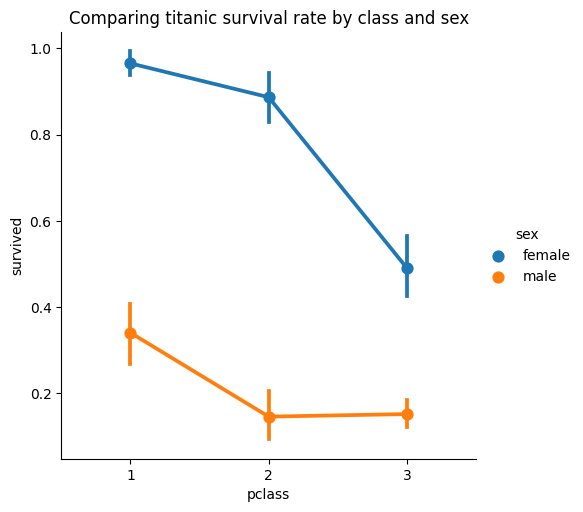

In [587]:
sns.factorplot('pclass', 'survived', hue='sex', data=data)
plt.title('Comparing titanic survival rate by class and sex');

H0: female in first class survival = female not in first class survival

H1: female in first class survival != female in first class survival

using 5% alpha level, confidene level = 95%

In [588]:
female_first_survived = survival_class_age['female'][1][1]
female_not_first_survived = survival_class_age['female'][2][1] + survival_class_age['female'][3][1]
female_first_pop = survival_class_age['female'][1].sum()
female_not_first_pop = survival_class_age['female'][2].sum() + survival_class_age['female'][3].sum()

In [589]:
hypothesis_statistics(female_first_survived, female_not_first_survived, female_first_pop, female_not_first_pop, 0.05)

'7.710109173417564 Test falls within rejection region, reject H0'

## Does age affect survival?
- There are 262 missing age in the dataset
- The youngest was 2 months old, oldest was 80 and average age was 30 years
- Children were proritized but class played a factor
- Middle age adults recorded the maximum number of deaths
- Old Adults has the least chance of surviving

In [590]:
data.age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: age, dtype: float64

since age is grouped, we can attempt to deduce the age bracket from name.

In [591]:
def bracket_age(x, name):
    if  x <= 0 or pd.isna(x):
        if 'Mr' in name:
            return 'Middle age adults'
        elif 'Dr' in name:
            return 'Middle age adults'
        elif 'Mrs' in name:
            return 'Middle age adults'
        elif 'Miss' in name:
            return 'Young adults'
        elif 'Master' in name:
            return '0 to 12'
        elif 'Ms' in name:
            return 'Young adults'
    elif x > 0 and x <= 12:
        return '0 to 12'
    elif x > 12 and x <= 18:
        return '12 to 18'
    elif x > 18 and x <= 30:
        return 'Young adults' 
    elif x > 30 and x <= 60:
        return 'Middle age adults'
    else:
        return 'Old Adults' 

data['age_bracket'] = data.apply(lambda x: bracket_age(x['age'],x['name']), axis = 1)
train['age_bracket'] = train.apply(lambda x: bracket_age(x['Age'],x['Name']), axis = 1)
test['age_bracket'] = test.apply(lambda x: bracket_age(x['Age'],x['Name']), axis = 1)

In [592]:
pd.crosstab([data['age_bracket'], data.pclass], data.survived )

survived                    0    1
age_bracket       pclass          
0 to 12           1         1    4
                  2         0   24
                  3        44   29
12 to 18          1         2   14
                  2        11    7
                  3        45   20
Middle age adults 1        84  128
                  2        75   38
                  3       238   46
Old Adults        1        15    6
                  2         5    1
                  3         5    1
Young adults      1        21   48
                  2        67   49
                  3       196   85

In [593]:
pd.crosstab( data.survived,[data['age_bracket'], data.pclass], normalize='columns' )

age_bracket 0 to 12               12 to 18                      \
pclass            1    2        3        1         2         3   
survived                                                         
0               0.2  0.0  0.60274    0.125  0.611111  0.692308   
1               0.8  1.0  0.39726    0.875  0.388889  0.307692   

age_bracket Middle age adults                     Old Adults            \
pclass                      1         2         3          1         2   
survived                                                                 
0                    0.396226  0.663717  0.838028   0.714286  0.833333   
1                    0.603774  0.336283  0.161972   0.285714  0.166667   

age_bracket           Young adults                      
pclass              3            1         2         3  
survived                                                
0            0.833333     0.304348  0.577586  0.697509  
1            0.166667     0.695652  0.422414  0.302491

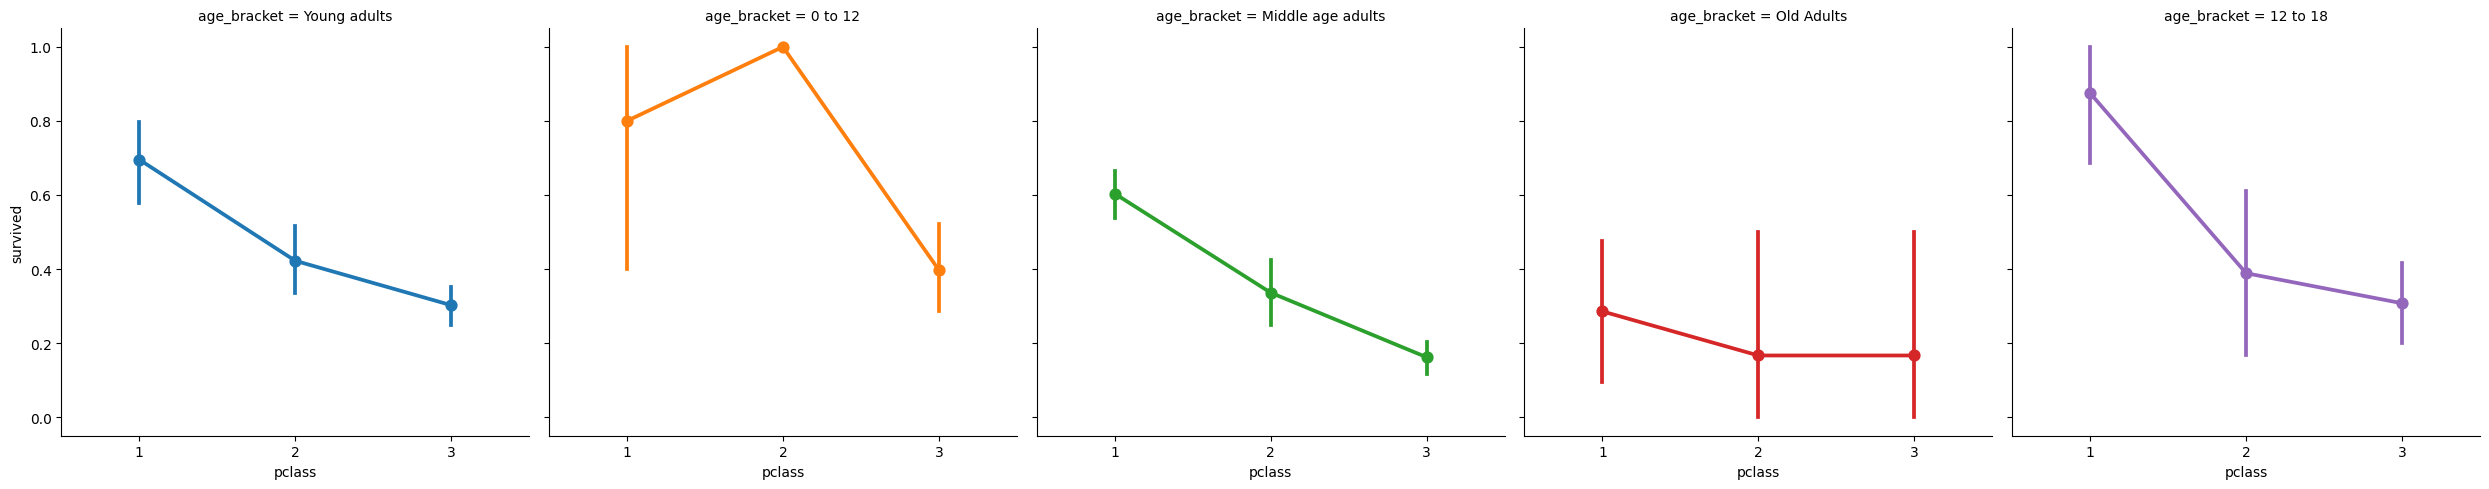

In [594]:
sns.factorplot('pclass', 'survived', hue='age_bracket', col='age_bracket', data=data);

## Did siblings/family die/survive together?
- passengers with 1 or 2 siblings have a higher chance of survival
- Passengers with more than 4 siblings are in the third class and they have no chance of survival. 
- about 68% of passengers had no  siblings or spouses on the ship, while 76% did not travel with parents or children
- passengers with parents or children have a higher chance of survival, but the number drops after 3 relations
- Therefore passengers with 1-3 parents/children/siblings have a higher survival chance

In [595]:
data.sibsp.value_counts(normalize = True)

0    0.680672
1    0.243697
2    0.032086
4    0.016807
3    0.015279
8    0.006875
5    0.004584
Name: sibsp, dtype: float64

In [596]:
data.parch.value_counts(normalize=True)

0    0.765470
1    0.129870
2    0.086325
3    0.006112
4    0.004584
5    0.004584
6    0.001528
9    0.001528
Name: parch, dtype: float64

In [597]:
pd.crosstab( data.survived,data.sibsp, normalize='columns' )

sibsp,0,1,2,3,4,5,8
survived,,,,,,,
0,0.653199,0.489028,0.547619,0.7,0.863636,1.0,1.0
1,0.346801,0.510972,0.452381,0.3,0.136364,0.0,0.0


In [598]:
pd.crosstab([data.sibsp, data.pclass], data.survived )

survived        0    1
sibsp pclass          
0     1        87  111
      2       113   69
      3       382  129
1     1        34   79
      2        39   43
      3        83   41
2     1         1    7
      2         6    6
      3        16    6
3     1         1    3
      2         0    1
      3        13    2
4     3        19    3
5     3         6    0
8     3         9    0

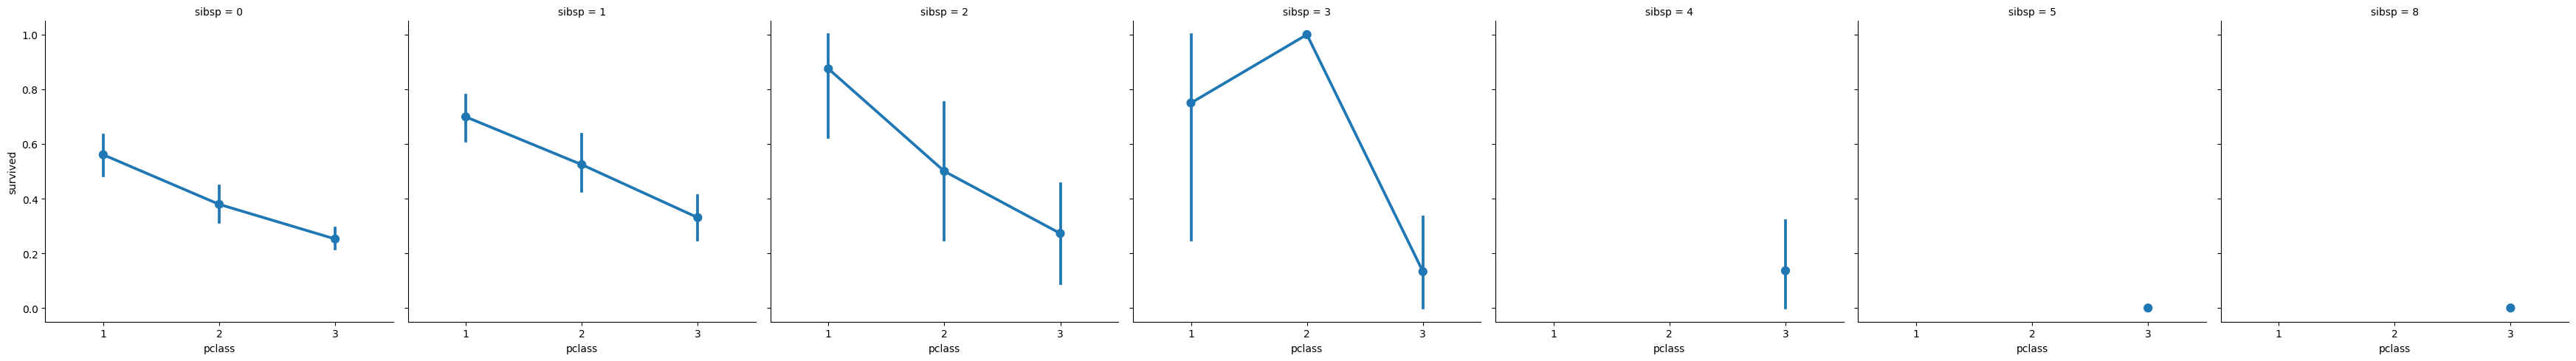

In [599]:
sns.factorplot('pclass', 'survived',  col='sibsp', data=data);

In [600]:
pd.crosstab( data.survived,data.parch, normalize='columns' )

parch,0,1,2,3,4,5,6,9
survived,,,,,,,,
0,0.664671,0.411765,0.495575,0.375,0.833333,0.833333,1.0,1.0
1,0.335329,0.588235,0.504425,0.625,0.166667,0.166667,0.0,0.0


## Fare
- Minimum fare is 0.
- The fare of first class has wide spread/distribution than the others. 
- There was a missing fare data for a passenger in third class who has no siblings or children, the data is imputted with the average of third class fare with no siblings/children

In [601]:
data.fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: fare, dtype: float64

In [602]:
data.groupby(['pclass'])['fare'].mean()

pclass
1    87.508992
2    21.179196
3    13.302889
Name: fare, dtype: float64

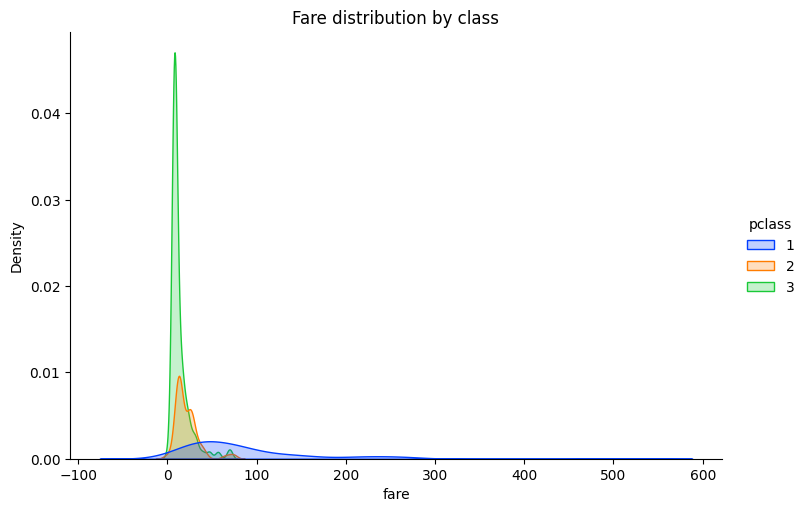

In [603]:
sns.displot(data=data, x='fare', hue='pclass', kind='kde', fill=True, palette=sns.color_palette('bright')[:3], height=5, aspect=1.5);
plt.title('Fare distribution by class');

In [604]:
test[test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_bracket
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Old Adults


In [605]:
test.Fare.isnull().sum()

1

In [606]:
mean_input = data[(data.pclass == 3) & (data.sibsp == 0) & (data.parch == 0)]['fare'].mean()

In [607]:
data.loc[data.fare.isnull(), 'fare'] = mean_input
test.loc[test.Fare.isnull(), 'Fare'] = mean_input

## Other features and feature engineering
- The name feature has only 2 unique values, duplicated has 380 unique values
- Cabin has a lot of missing values, thus wont be considered
- Embarked feature has 2 missing values, the two missing values are for passengers in first class. The two missing values will be imputted with S, since most first class passengers boarded on station S 

In [608]:
data.name.duplicated().sum()

2

In [609]:
data.isnull().sum()

pclass            0
survived          0
name              0
sex               0
age             263
sibsp             0
parch             0
ticket            0
fare              0
cabin          1014
embarked          2
boat            823
body           1188
home.dest       564
age_bracket       0
dtype: int64

In [610]:
data.ticket.duplicated().sum()

380

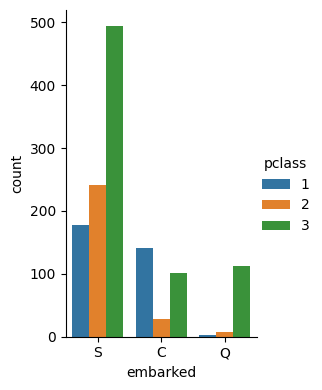

In [611]:
g = sns.catplot(x="embarked", hue="pclass", 
                data=data, kind="count",
                height=4, aspect=.7);

In [612]:
data.groupby('pclass')['embarked'].value_counts()

pclass  embarked
1       S           177
        C           141
        Q             3
2       S           242
        C            28
        Q             7
3       S           495
        Q           113
        C           101
Name: embarked, dtype: int64

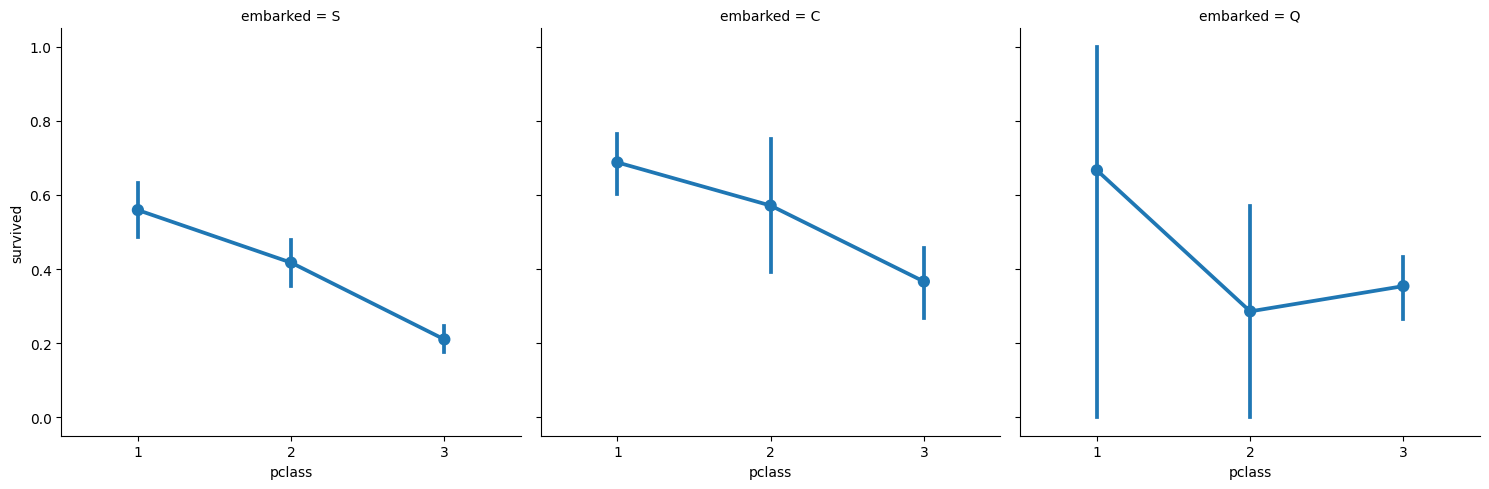

In [613]:
sns.factorplot('pclass', 'survived',  col='embarked', data=data);

In [614]:
data[data.embarked.isnull()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,age_bracket
168,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,6,NaN,NaN,Middle age adults
284,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,6,NaN,"Cincinatti, OH",Old Adults


In [615]:
data.loc[data.embarked.isnull(), 'embarked'] = 'S'
train.loc[train.Embarked.isnull(), 'Embarked'] = 'S'

# Correlation

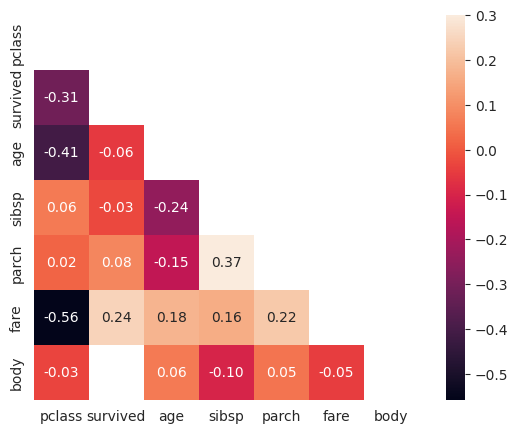

In [616]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, fmt='.2f')
plt.show()

# Modelling

## Data Conversion

The PassengerId, Name, Ticket, Cabin and Age wont be used for the modeling as they are either unique, have lots of missing data and transformed into a different feature in the case of Age

Sex, embarked and age_bracket will be encoded

In [617]:
le = LabelEncoder()
le.fit(train['age_bracket'])
train['label_age'] = le.transform(train['age_bracket'])
test['label_age'] = le.transform(test['age_bracket'])

In [618]:
le.classes_

array(['0 to 12', '12 to 18', 'Middle age adults', 'Old Adults',
       'Young adults'], dtype=object)

In [619]:
scaler = MinMaxScaler()
scaler.fit(train['Fare'].values.reshape(-1,1))
train['Fare'] = scaler.transform(train['Fare'].values.reshape(-1,1))
test['Fare'] = scaler.transform(test['Fare'].values.reshape(-1,1))

In [620]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_bracket,label_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0.014151,NaN,S,Young adults,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,0.139136,C85,C,Middle age adults,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,0.015469,NaN,S,Young adults,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,0.103644,C123,S,Middle age adults,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,0.015713,NaN,S,Middle age adults,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,0.025374,NaN,S,Young adults,4
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,0.058556,B42,S,Young adults,4
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,0.045771,NaN,S,Young adults,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,0.058556,C148,C,Young adults,4


In [621]:
train['Sex'].replace(['male','female'],[0,1],inplace=True)
train['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
test['Sex'].replace(['male','female'],[0,1],inplace=True)
test['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)

In [622]:
train_x = train.drop(columns=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'Age', 'age_bracket'])
test_x = test.drop(columns=['PassengerId',  'Name', 'Ticket', 'Cabin', 'Age', 'age_bracket'])
train_y = train['Survived']

In [623]:
RANDOM_STATE = 100
folds = KFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)

## Baseline Model
For the baseline model, sex and pclass feature will be used. 
- feature importance shows that pclass is 100% used to predict survival
- The cross validation result differs from OOB result

In [624]:
train_b = train_x[['Pclass', 'Sex']]

In [625]:
scoring = ['precision', 'recall', 'f1', 'roc_auc', 'accuracy']
rf = RandomForestClassifier(random_state=RANDOM_STATE,class_weight='balanced', bootstrap=True, oob_score=True, min_samples_leaf=0.3)
scores = cross_validate(rf, train_b, train_y, scoring=scoring, cv = folds, return_train_score=True)

In [626]:
rf.fit(train_b, train_y)
rf.oob_score_

0.621773288439955

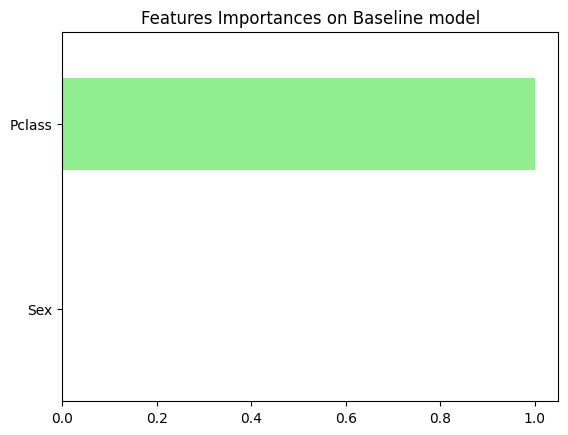

In [627]:
importances = pd.Series(data=rf.feature_importances_,
                        index= train_b.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances on Baseline model')
plt.show()

In [628]:
rst = {
    "model": "Baseline",
    "OOB": rf.oob_score_,
    "test accuracy": scores['test_accuracy'].mean(),
    "test f1": scores['test_f1'].mean()
}
result = pd.DataFrame(rst, index = [1])

In [629]:
result

,model,OOB,test accuracy,test f1
1,Baseline,0.621773,0.682372,0.431827


## All Features
All 7 features will be used with Random Forest default features. 
- The features fare and sex have higher importance than the other features
- The OOB score and cross validation test accuracy are almost equal at 0.803 and 0.800

In [630]:
rf_d = RandomForestClassifier(random_state=RANDOM_STATE, bootstrap=True, oob_score=True)
scores_d = cross_validate(rf_d, train_x, train_y, scoring=scoring, cv = folds, return_train_score=True)

In [631]:
rf_d.fit(train_x, train_y)
rf_d.oob_score_

0.8035914702581369

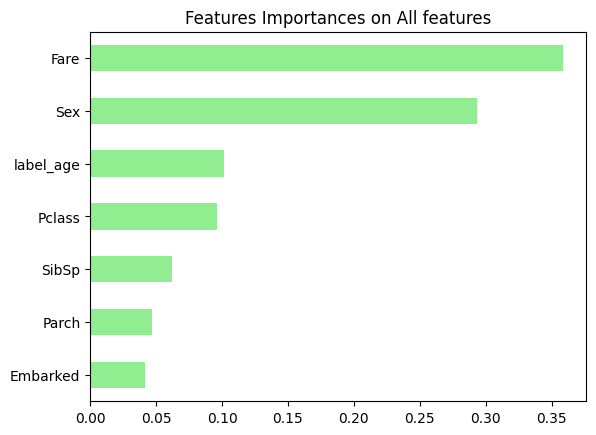

In [632]:
importances = pd.Series(data=rf_d.feature_importances_,
                        index= train_x.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances on All features')
plt.show()

In [633]:
rst = {
    "model": "All Features",
    "OOB": rf_d.oob_score_,
    "test accuracy": scores_d['test_accuracy'].mean(),
    "test f1": scores_d['test_f1'].mean()
}
result = result.append(rst, ignore_index = True)

In [634]:
result

,model,OOB,test accuracy,test f1
0,Baseline,0.621773,0.682372,0.431827
1,All Features,0.803591,0.800187,0.731159


## Optimizing Hyperparameter

Using Grid Search CV to get the best parameters for Random Forest, sex, pclass and fare have the highest importance


In [635]:
rf_g = RandomForestClassifier(random_state=RANDOM_STATE, bootstrap=True, oob_score=True)
params_rf = {
    'max_depth': [3, 4, 5, 6],
    'max_features': [2, 3, 4, 5, 7],
    'min_samples_leaf': [0.03, 0.05, 0.07],
    'n_estimators': [100, 200, 300, 400, 500]
}
grid_rf = GridSearchCV(estimator=rf_g, param_grid=params_rf, cv = 10, scoring = 'accuracy', 
    verbose=1, n_jobs=-1)
grid_rf.fit(train_x, train_y)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(oob_score=True, random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [2, 3, 4, 5, 7],
                         'min_samples_leaf': [0.03, 0.05, 0.07],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=1)

In [636]:
best_model = grid_rf.best_estimator_
best_model

RandomForestClassifier(max_depth=6, max_features=3, min_samples_leaf=0.03,
                       n_estimators=500, oob_score=True, random_state=100)

In [637]:
grid_rf.best_score_

0.8092134831460674

In [641]:
scores_cv = cross_validate(best_model, train_x, train_y, scoring=scoring, cv = folds, return_train_score=True)

In [638]:
best_model.fit(train_x, train_y)
best_model.oob_score_

0.8035914702581369

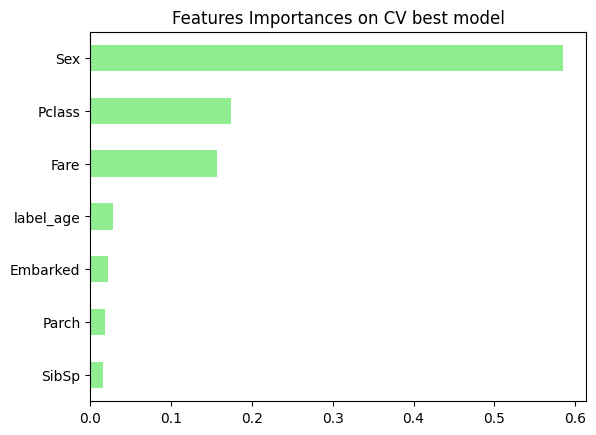

In [639]:
importances = pd.Series(data=best_model.feature_importances_,
                        index= train_x.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances on CV best model')
plt.show()

In [642]:
rst = {
    "model": "CV Best Estimator",
    "OOB": best_model.oob_score_,
    "test accuracy": scores_cv['test_accuracy'].mean(),
    "test f1": scores_cv['test_f1'].mean()
}
result = result.append(rst, ignore_index = True)

In [643]:
result

,model,OOB,test accuracy,test f1
0,Baseline,0.621773,0.682372,0.431827
1,All Features,0.803591,0.800187,0.731159
2,CV Best Estimator,0.803591,0.796866,0.687696


# Conclusion
- Some of the importance features are sex, pclass, fare and age. Which is fairly consistent with the observations during EDA
- Observing the results from the trained model, the `all features` model will be used for predicting the test

In [644]:
pred = rf_d.predict(test_x)

In [650]:
test['pred'] = pred
test.to_csv('predicted_test.csv')